# 活性化関数

活性化関数はNNに非線形性を付加するため、DLにおいて非常に重要な役割を担っています。  

In [10]:
import os
import json
import math
import japanize_matplotlib
import numpy as np 
import time

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        # GPUありの場合
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

def get_device():
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
    elif torch.backends.mps.is_built():
        device = torch.device("mps:0")
    else:
        device = torch.device("cpu")
    return device

In [11]:
# pytorchでデータをダウンロードするときのパス（重複してDWしないため）
DATASET_PATH = "../data"
# モデルの保存先
CHECKPOINT_PATH = "../models/03_activation_fn"
os.makedirs(DATASET_PATH, exist_ok=True)
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# 再現性のためにseedを固定する
set_seed(42)

# device情報を取得する
device = get_device()
print(f"deviceは{device}です")

deviceはmps:0です


## 様々な活性化関数

**baseとなるクラス**

これ以降独自の活性化関数を定義するので、継承元になるベースのクラスを定義しておきます。

In [12]:
class BaseActivationFunc(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.name = self.__class__.__name__
        self.config = {"name": self.name}

#### Sigmoid

最も古い活性化関数の１つです。出力値は0~1の間にあり、各ニューロンの値を正規化できます。しかし、Xの値が非常に大きい/小さい場合、出力にほとんど差がなくなり、勾配消失問題が発生します。

In [13]:
class Sigmoid(BaseActivationFunc):
    
    def forward(self, x):
        return 1 / (1 + torch.exp(-x))

#### Tanh

最も古い活性化関数の１つです。出力値は-1~1の間にあります。これもSigmoidと同様に勾配消失問題の影響が大きいです。

In [14]:
class Tanh(BaseActivationFunc):
    
    def forward(self, x):
        x_exp, neg_x_exp = torch.exp(x), torch.exp(-x)
        return (x_exp - neg_x_exp) / (x_exp + neg_x_exp)

#### ReLU

ReLUは単純な関数形にもかかわらず、sigmoidやtanhと比較して、大きな利点があります。それは、大きな値に対して強力で安定した勾配を持つということです。そのため、SigmoidやTanhと比較して勾配消失問題に対して強いです。この考えに基づき、ReLUの派生として様々な関数が提案されています。  
しかし、入力が0または負の場合、出力が０になるため、情報が伝わらない（dead neurons）が発生することが知られています。

In [15]:
class ReLU(BaseActivationFunc):
    
    def forward(self, x):
        return x * (x > 0).float()

#### LeaklyReLU

LeakyReLUは、負の部分のゼロの範囲を小さな勾配に置き換え、この部分にも勾配が流れるようにするものです。  
入力が0より小さい場合、入力にα倍した値を返します。負の領域にも勾配があるため、RELUで生じるdead neurons問題を防ぐ効果があります。

In [16]:
class LeakyReLU(BaseActivationFunc):
    
    def __init__(self, alpha=0.1):
        super().__init__()
        self.config["alpha"] = alpha
        
    def forward(self, x):
        return torch.where(x > 0, x, self.config["alpha"] * x)

#### PRELU

PRELUはParametric ReLUの略で、LeakyReLUと同様に、負の部分のゼロの範囲を小さな勾配に置き換え、この部分にも勾配が流れるようにするものです。  
異なる点はα倍の値が、LeakyReLUでは手動で設定した固定値なのに対し、PReLUでは学習によって動的に決まるパラメーターである点です。

ここで、パラメータとして学習させたい変数は``nn.parameter.Parameter``を用いて定義します。

In [17]:
from torch.nn.parameter import Parameter

class PReLU(BaseActivationFunc):
    
    def __init__(self, init=0.1, device=None):
        super().__init__()
        factory_kwargs = {'device': device}
        self.weight = Parameter(torch.empty(1, **factory_kwargs).fill_(init))

        self.config["init"] = init

    def forward(self, x):
        return torch.where(x > 0, x, self.weight * x)

#### ELU

ELUは、負の部分を指数関数的な減衰に置き換えるものです。dead neuronsを防ぎますが、大きな負の値ではさちることになります。

In [18]:
class ELU(BaseActivationFunc):
    
    def forward(self, x):
        return torch.where(x > 0, x, torch.exp(x)-1)

#### GELU

GELUはGaussian Error Linear Unitsの略です。関数形は以下で表されます。

$$GELU(x) = x\Phi(x)$$

ここで、$\Phi$は標準正規分布の分布関数のようですが、実際は正規分布である必要もないようです。しかし、これは解析的に計算できないのでこれを以下のように近似しています。  
pytorchのオプションでは``approximate = 'tanh'``とした時と同じになります。

$${GELU}(x) = 0.5 * x * (1 + \text{Tanh}(\sqrt(2 / \pi) * (x + 0.044715 * x^3)))$$

以下の記事がわかりやすかったです。GELUではドロップアウトのようにインプットの値に応じて確率的に0または1を掛けているのと同じようです。

https://data-analytics.fun/2020/09/04/understanding-gelu/

In [19]:
class GELU(BaseActivationFunc):
    
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3))))

#### Swish

Swishは他の活性化関数と比較して、滑らかで非単調（勾配に符号の変化がある）であることが特徴です。これは、特に深いネットワークにおいて、標準的なReLU活性化関数で生じる死んだニューロン(dead neurons)を防ぐことが示されています。

In [20]:
class Swish(BaseActivationFunc):
    
    def forward(self, x):
        return x * torch.sigmoid(x)

#### Mish

こちらもReLUやSwishから改良されたものになります。ReLU同様上限がないため、学習速度の低下が起こりづらく、下限があるため強い正則化をかけることができます。また、ReLUは０の点で不連続になるため勾配を用いる場合学習がおかしくなる可能性がありますが、Mishは∞階まで微分できるため問題ないです。

In [21]:
class Mish(BaseActivationFunc):
    
    def __init__(self):
        super().__init__()
        self.tanh = Tanh()
    
    def forward(self, x):
        return x*self.tanh(torch.log(1+torch.exp(x)))

後でこれらの関数を使用するので、辞書にまとめておきます。

In [22]:
dict_act_fn = {
    "sigmoid": Sigmoid,
    "tanh": Tanh,
    "relu": ReLU,
    "leakyrelu": LeakyReLU,
    "prelu": PReLU,
    "elu": ELU,
    "gelu": GELU,
    "swish": Swish,
    "mish": Mish
}

## 勾配情報の可視化

ここでは、活性化関数の形状と勾配を合わせて可視化します。  
可視化すると各関数の連続性、上限/下限有無、非線形性を見て理解できますね。

In [23]:
def get_grads(act_fn, x):
    # 勾配情報が欲しいので、requires_grad_()を実施する
    x = x.clone().requires_grad_() 
    out = act_fn(x)
    # sum()は各エレメントに対し等しい勾配を与えるため、結果として問題なし
    out.sum().backward()
    return x.grad

def vis_act_fn(name, act_fn, ax, x):
    y = act_fn(x)
    y_grads = get_grads(act_fn, x) 
   # 可視化のためにCPUhe戻す 
    x, y, y_grads = x.cpu().numpy(), y.cpu().detach().numpy(), y_grads.cpu().numpy()
    ax.plot(x, y, linewidth=2, label="ActFn")
    ax.plot(x, y_grads, linewidth=2, label="Gradient")
    ax.set_title(act_fn.name)
    ax.legend()
    ax.set_ylim(-1.5, x.max())

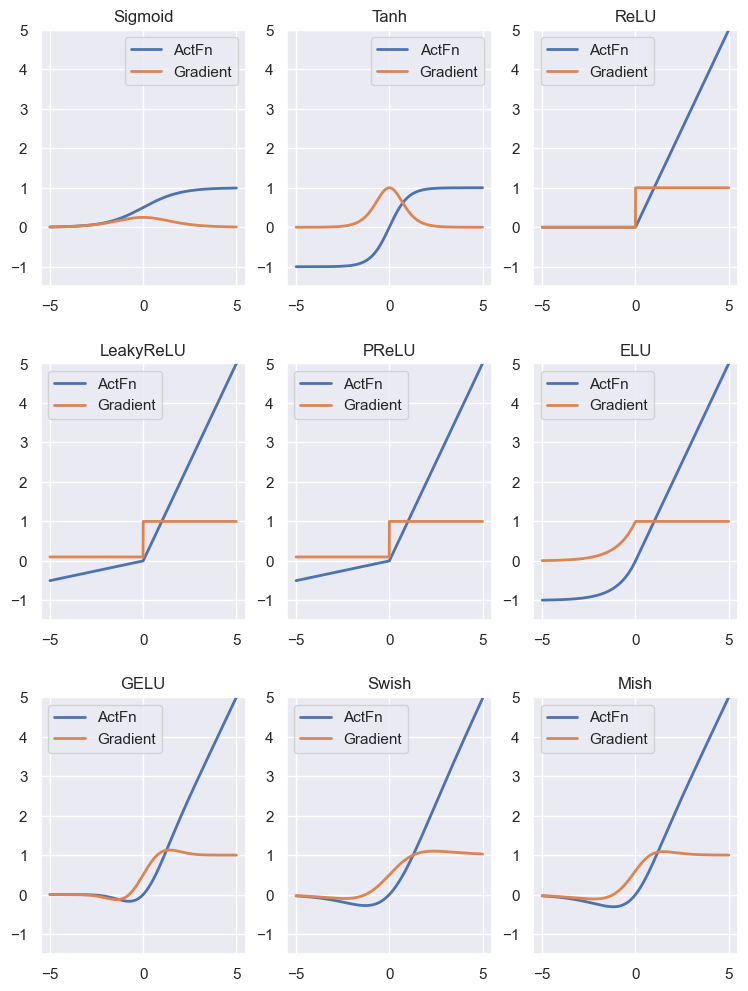

In [24]:
x = torch.linspace(-5, 5, 1000)

rows = math.ceil(len(dict_act_fn)/3.0)
fig, ax = plt.subplots(rows, 3, figsize=(9, rows*4))
for i, (name, act_fn) in enumerate(dict_act_fn.items()):
    act_fn = act_fn()
    vis_act_fn(name, act_fn, ax[divmod(i,3)], x)
fig.subplots_adjust(hspace=0.3)
plt.show()

## 活性化関数の効果検証

ここでは、FashionMNISTのデータセットを使用してNNの学習を行うことで活性化関数の効果を見ていきます。  
FashionMNISTはMNISTより難しい課題で、ファッション系のクラス１０種類を含んだ画像データです。

#### ネットワークの定義

ここでは、画像を１次元のテンソルとして単純なネットワークを構築します。
Dense, ActivationFnが連続しているだけですね。

In [25]:
class BaseNetwork(nn.Module):
    
    def __init__(self, act_fn, input_size=784, num_classes=10, hidden_sizes=[512, 256, 256, 128]):
        """
        Inputs:
            act_fn - 今回試したい活性化関数
            input_size - 画像のサイズ
            num_classes - 予測したいクラス数
            hidden_sizes - 隠れ層のサイズのリスト
        """
        super().__init__()
        
        layers = []
        layer_sizes = [input_size] + hidden_sizes
        for layer_index in range(1, len(layer_sizes)):
            layers += [nn.Linear(layer_sizes[layer_index-1], layer_sizes[layer_index]),
                       act_fn()]
        layers += [nn.Linear(layer_sizes[-1], num_classes)]
        # リスト情報からlayerを追加
        self.layers = nn.Sequential(*layers)
        
        # モデルを保存/読み込む際に必要な情報を格納
        self.config = {"act_fn": act_fn().config, "input_size": input_size, "num_classes": num_classes, "hidden_sizes": hidden_sizes} 
        
    def forward(self, x):
        # ここで、画像を１次元へ変換
        x = x.view(x.size(0), -1)
        out = self.layers(x)
        return out    

#### データセットのダウンロード

``torchvision.datasets.FashionMNIST``かたデータのダウンロードを行います。
``FashionMNIST``の引数の意味としては``root``はデータをダウンロードする場所、``train=True``は訓練データ、``transform``はデータを``__getitem__()``で取得するときに一緒に行う変換、``download=True``はネットかわデータをダウンロードするという意味です。

上記の``transofrom``に渡す関数としてはTensor化する``transofroms.ToTensor()``と与えられた平均と標準偏差で正規化を``transforms.Normalize((mean), (std))``を与えています。ここでは、平均と標準偏差を0.5と決め打ちで与えていますが、学習データの平均と標準偏差を計算した値を指定する方法も取られます。これは経験則的にどちらでもうまく機能することが示されているため、どちらかが悪いというわけではないかと思います。注意点としては、学習済みモデルを使用するときはその学習データと同様の変換（訓練データの平均と標準偏差を指定する）を行う必要があるところです。

In [26]:
import torchvision
from torchvision.datasets import FashionMNIST
from torchvision import transforms

# __getitem__()で取得する各画像に対して行う変換。ここではTensor化と正規化
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.5,), (0.5,))])

# 訓練データのダウンロードとデータの分割
train_dataset = FashionMNIST(root=DATASET_PATH, train=True, transform=transform, download=True)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

# テストデータのダウンロード
test_set = FashionMNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

# DataLoaderの定義
# 実際のより大きな画像/モデルの場合はbatch_sizeはメモリに制限があり、より少なく設定されると思われます
train_loader = data.DataLoader(train_set, batch_size=1024, shuffle=True, drop_last=False)
val_loader = data.DataLoader(val_set, batch_size=1024, shuffle=False, drop_last=False)
test_loader = data.DataLoader(test_set, batch_size=1024, shuffle=False, drop_last=False)

In [27]:
# -1~1の範囲に正規化されていることを確認
train_dataset[0][0].cpu().numpy().min(), train_dataset[0][0].cpu().numpy().max()

(-1.0, 1.0)

In [28]:
# もしNormalizeの平均と標準偏差を決め打ちで0.5としない場合は、以下のように元訓練画像群から計算した平均と標準偏差を指定します
print("Mean", (train_dataset.data.float() / 255.0).mean().item())
print("Std", (train_dataset.data.float() / 255.0).std().item())

Mean 0.28604060411453247
Std 0.3530242443084717


In [29]:
# __getitem__()で取得する各画像に対して行う変換。ここではTensor化と正規化
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.2861,), (0.3530,))])

# 訓練データのダウンロードとデータの分割
train_dataset = FashionMNIST(root=DATASET_PATH, train=True, transform=transform, download=True)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

# テストデータのダウンロード
test_set = FashionMNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

# DataLoaderの定義
# 実際のより大きな画像/モデルの場合はbatch_sizeはメモリに制限があり、より少なく設定されると思われます
train_loader = data.DataLoader(train_set, batch_size=1024, shuffle=True, drop_last=False)
val_loader = data.DataLoader(val_set, batch_size=1024, shuffle=False, drop_last=False)
test_loader = data.DataLoader(test_set, batch_size=1024, shuffle=False, drop_last=False)

In [30]:
# 1batchに対して各統計量を計算して確認します
# 1batchなので厳密に平均０、標準偏差１になってはないですが確認できました。
imgs, _ = next(iter(train_loader))
print(f"Mean: {imgs.mean().item():5.3f}")
print(f"Standard deviation: {imgs.std().item():5.3f}")
print(f"Maximum: {imgs.max().item():5.3f}")
print(f"Minimum: {imgs.min().item():5.3f}")

Mean: 0.016
Standard deviation: 1.005
Maximum: 2.022
Minimum: -0.810


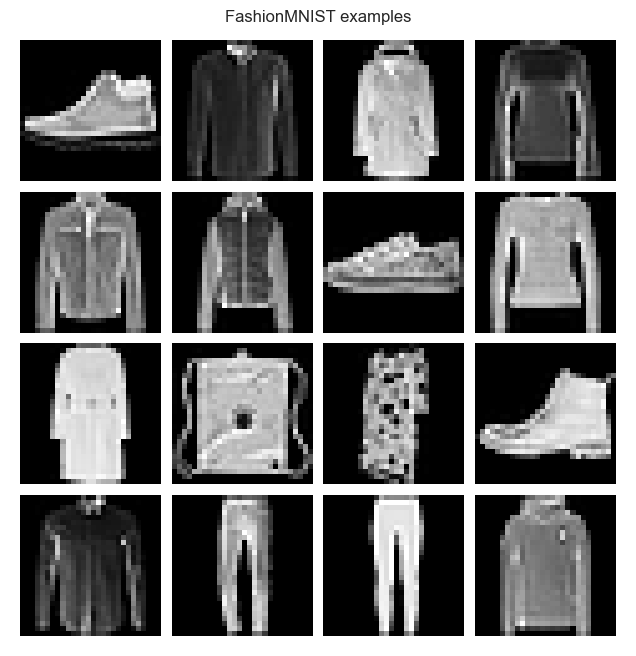

In [31]:
# ここでデータを可視化してみます
exmp_imgs = [train_set[i][0] for i in range(16)]
img_grid = torchvision.utils.make_grid(torch.stack(exmp_imgs, dim=0), nrow=4, normalize=True, pad_value=1)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("FashionMNIST examples")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

#### 勾配の可視化

活性化関数の重要な点としては、勾配をいかにネットワーク全体で伝播できるかという点です。ここで、５０層以上の深いネットワークを考えると、入力層へ来るまでに５０回活性化関数を通ることになります。そのため、勾配には適度な大きさが必要で、勾配が１よりかなり小さいと勾配消失がおきますし、１より大きいと勾配が急激に増え爆発します。

ここでは、初期化したばかりのネットワークを通して、活性化関数がいかに勾配に影響を与えるかを見ていきます。

In [32]:
def visualize_gradients(net, color="C0"):
    net.eval()
    # 関数が呼び出されるたびにDataLoaderを作成し、同じデータで試せるようにするあ
    small_loader = data.DataLoader(train_set, batch_size=256, shuffle=False)
    imgs, labels = next(iter(small_loader))
    imgs, labels = imgs.to(device), labels.to(device)
    
    # 1batchだけ計算して、勾配を計算する
    net.zero_grad()
    preds = net(imgs)
    loss = F.cross_entropy(preds, labels)
    loss.backward()
    # Linearのbiasを除いたWeightの勾配情報のみ取得する
    grads = {name: params.grad.data.view(-1).cpu().clone().numpy() for name, params in net.named_parameters() if "weight" in name}
    net.zero_grad()
    
    ## Plotting
    columns = len(grads)
    fig, ax = plt.subplots(1, columns, figsize=(columns*3.5, 2.5))
    for i, key in enumerate(grads):
        key_ax = ax[i%columns]
        sns.histplot(data=grads[key], ax=key_ax, color=color, kde=True)
        key_ax.set_title(str(key))
        key_ax.set_xlabel("Grad magnitude")
    fig.suptitle(f"Gradient magnitude distribution for activation function {net.config['act_fn']['name']}", fontsize=14, y=1.05)
    fig.subplots_adjust(wspace=0.45)
    plt.show()
    plt.close() 

Sigmoidでは、出力層の勾配は0.1程度もあり非常に大きいが、入力層は10^-5のオーダーでかなり小さい。このように層毎に大きさが異なると各層毎に適切な学習率を設定することは困難です。他の活性化関数は全ての層で大体同じような勾配の大きさを持つことがわかります。

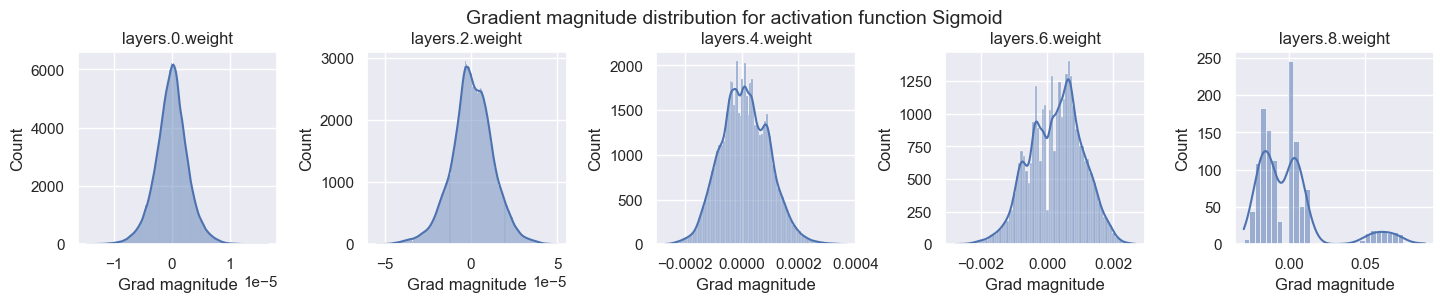

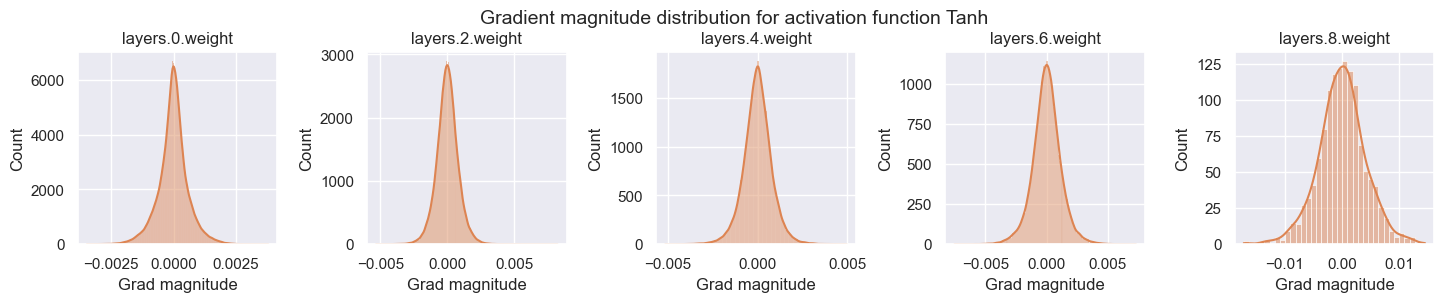

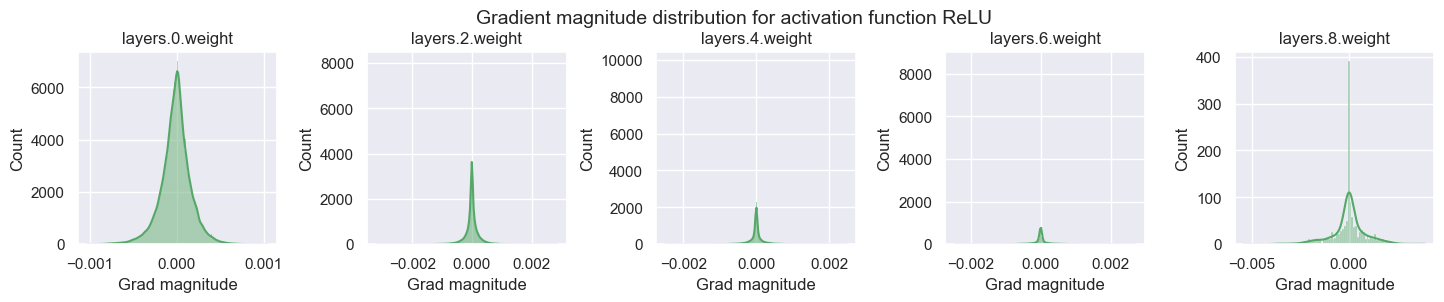

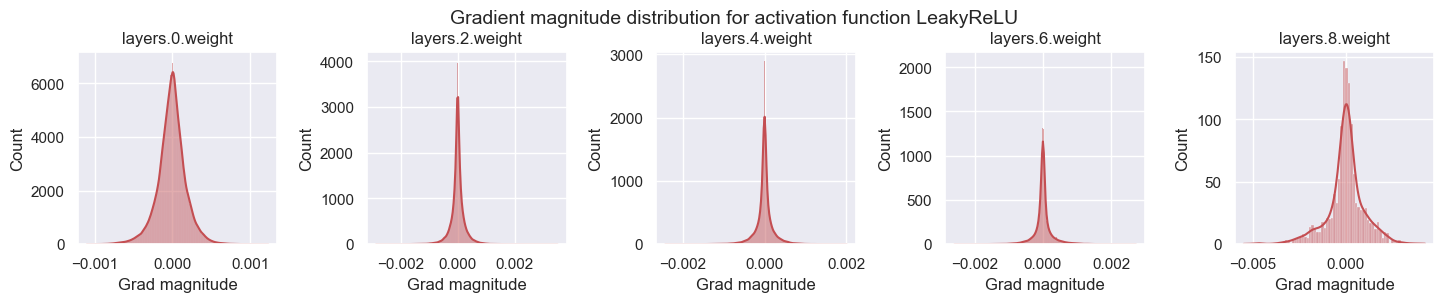

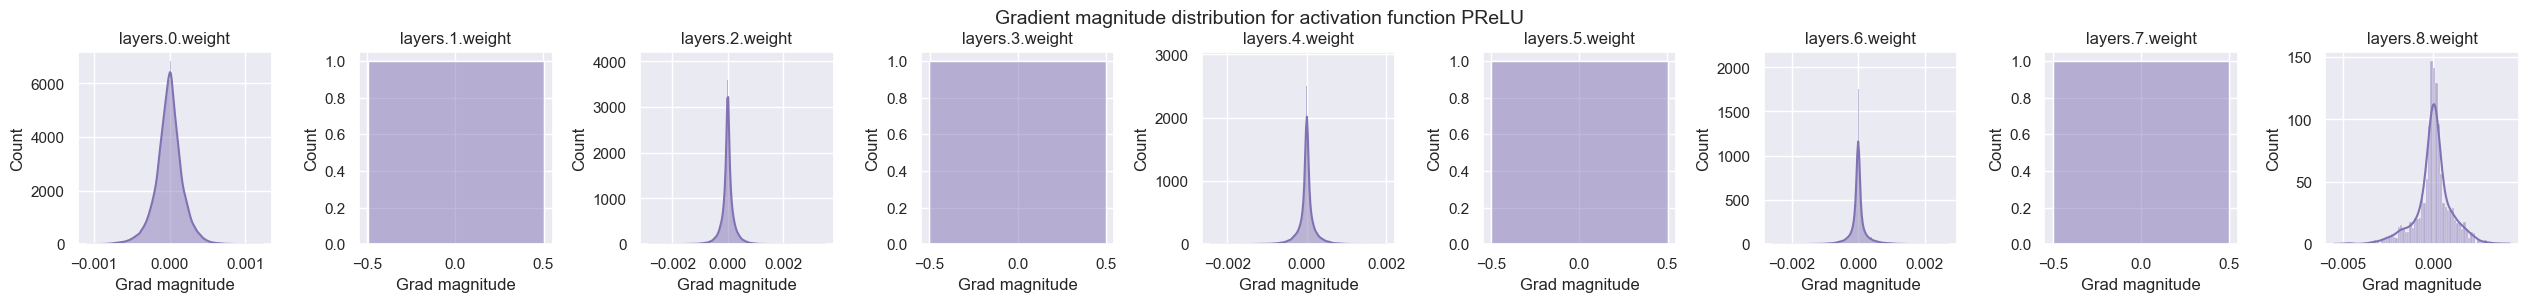

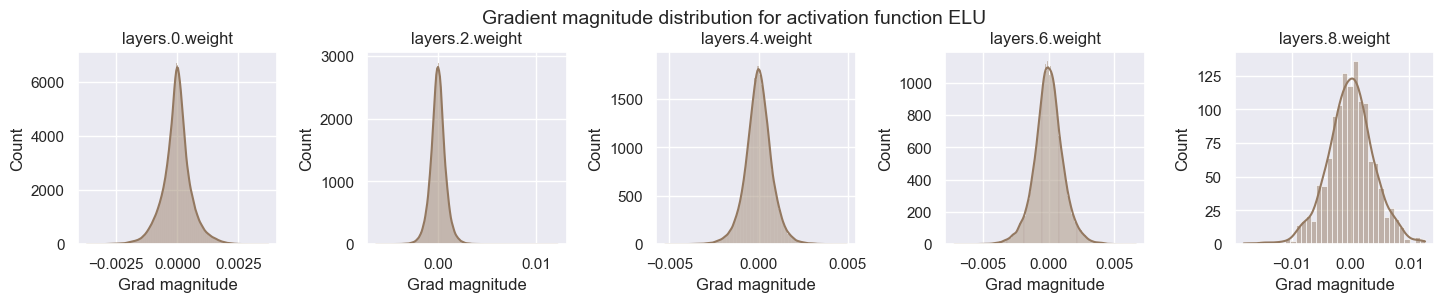

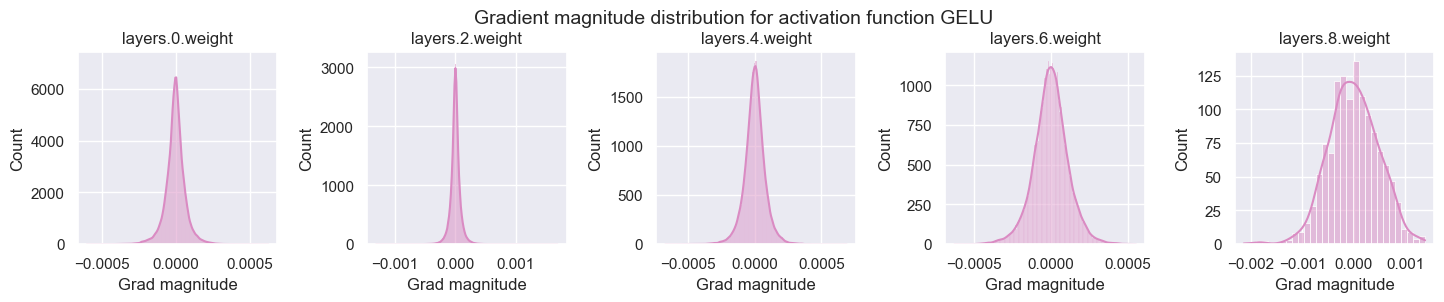

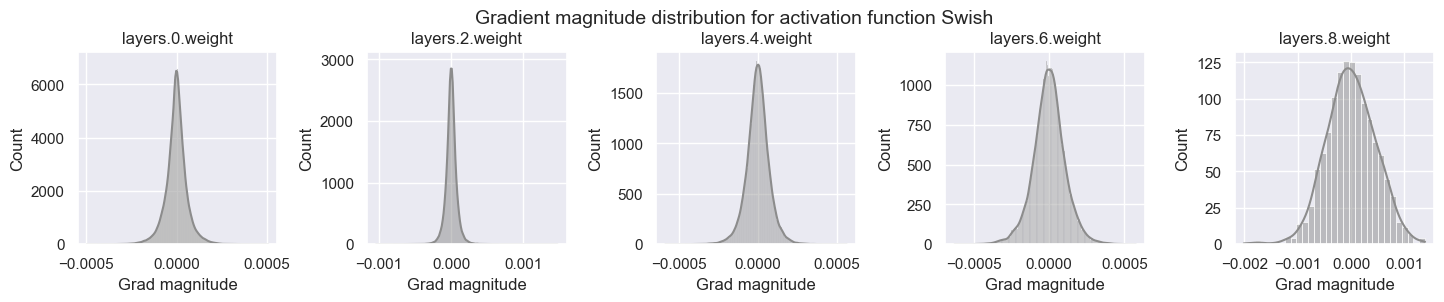

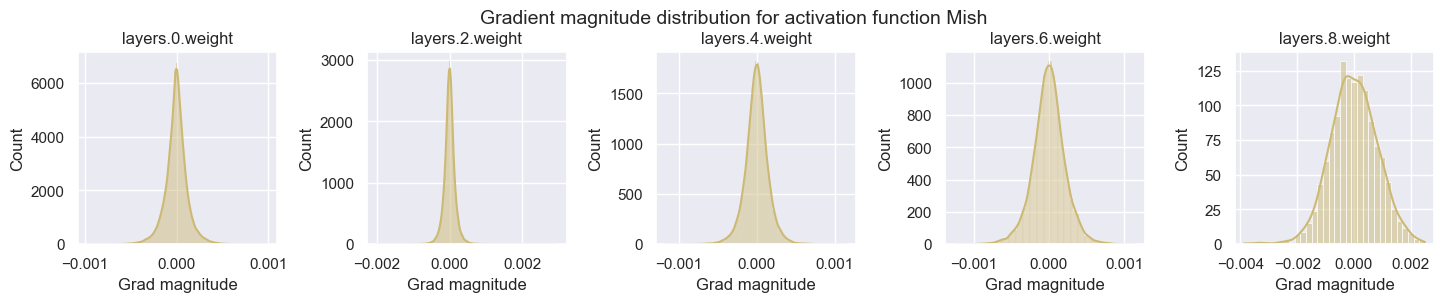

In [33]:
for i, act_fn_name in enumerate(dict_act_fn):
    # 各活性化関数毎に同じ初期化がされるようにシードを設定する
    set_seed(42)
    act_fn = dict_act_fn[act_fn_name]
    net_actfn = BaseNetwork(act_fn=act_fn).to(device)
    visualize_gradients(net_actfn, color=f"C{i}")

#### モデルの学習

活性化関数毎のモデル性能の差を見ていきます。

In [34]:
def _get_config_file(model_path, model_name):
    # Name of the file for storing hyperparameter details
    return os.path.join(model_path, model_name + ".config")

def _get_model_file(model_path, model_name):
    # Name of the file for storing network parameters
    return os.path.join(model_path, model_name + ".tar")

def load_model(model_path, model_name, net=None):
    """
    Loads a saved model from disk.
    
    Inputs:
        model_path - Path of the checkpoint directory
        model_name - Name of the model (str)
        net - (Optional) If given, the state dict is loaded into this model. Otherwise, a new model is created.
    """
    config_file, model_file = _get_config_file(model_path, model_name), _get_model_file(model_path, model_name)
    assert os.path.isfile(config_file), f"Could not find the config file \"{config_file}\". Are you sure this is the correct path and you have your model config stored here?"
    assert os.path.isfile(model_file), f"Could not find the model file \"{model_file}\". Are you sure this is the correct path and you have your model stored here?"
    with open(config_file, "r") as f:
        config_dict = json.load(f)
    if net is None:
        act_fn_name = config_dict["act_fn"].pop("name").lower()
        act_fn = dict_act_fn[act_fn_name] #(**config_dict.pop("act_fn"))
        config_dict.pop("act_fn")
        net = BaseNetwork(act_fn=act_fn, **config_dict)
    net.load_state_dict(torch.load(model_file, map_location=device))
    return net
    
def save_model(model, model_path, model_name):
    """
    Given a model, we save the state_dict and hyperparameters.
    
    Inputs:
        model - Network object to save parameters from
        model_path - Path of the checkpoint directory
        model_name - Name of the model (str)
    """
    config_dict = model.config
    os.makedirs(model_path, exist_ok=True)
    config_file, model_file = _get_config_file(model_path, model_name), _get_model_file(model_path, model_name)
    with open(config_file, "w") as f:
        json.dump(config_dict, f)
    torch.save(model.state_dict(), model_file)

def train_model(net, model_name, max_epochs=50, patience=7, batch_size=256, overwrite=False):
    """
    Train a model on the training set of FashionMNIST
    
    Inputs:
        net - Object of BaseNetwork
        model_name - (str) Name of the model, used for creating the checkpoint names
        max_epochs - Number of epochs we want to (maximally) train for
        patience - If the performance on the validation set has not improved for #patience epochs, we stop training early
        batch_size - Size of batches used in training
        overwrite - Determines how to handle the case when there already exists a checkpoint. If True, it will be overwritten. Otherwise, we skip training.
    """
    file_exists = os.path.isfile(_get_model_file(CHECKPOINT_PATH, model_name))
    if file_exists and not overwrite:
        print("Model file already exists. Skipping training...")
    else:
        if file_exists:
            print("Model file exists, but will be overwritten...")
            
        # Defining optimizer, loss and data loader
        optimizer = torch.optim.SGD(net.parameters(), lr=1e-2, momentum=0.9) # Default parameters, feel free to change
        loss_module = nn.CrossEntropyLoss() 
        train_loader_local = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True)

        val_scores = []
        best_val_epoch = -1
        for epoch in range(max_epochs):
            ############
            # Training #
            ############
            net.train()
            true_preds, count = 0., 0
            for imgs, labels in tqdm(train_loader_local, desc=f"Epoch {epoch+1}", leave=False):
                imgs, labels = imgs.to(device), labels.to(device) # To GPU
                optimizer.zero_grad() # Zero-grad can be placed anywhere before "loss.backward()"
                preds = net(imgs)
                loss = loss_module(preds, labels)
                loss.backward()
                optimizer.step()
                # Record statistics during training
                true_preds += (preds.argmax(dim=-1) == labels).sum()
                count += labels.shape[0]
            train_acc = true_preds / count

            ##############
            # Validation #
            ##############
            val_acc = test_model(net, val_loader)
            val_scores.append(val_acc)
            print(f"[Epoch {epoch+1:2d}] Training accuracy: {train_acc*100.0:05.2f}%, Validation accuracy: {val_acc*100.0:05.2f}%")

            if len(val_scores) == 1 or val_acc > val_scores[best_val_epoch]:
                print("\t   (New best performance, saving model...)")
                save_model(net, CHECKPOINT_PATH, model_name)
                best_val_epoch = epoch
            elif best_val_epoch <= epoch - patience:
                print(f"Early stopping due to no improvement over the last {patience} epochs")
                break

        # Plot a curve of the validation accuracy
        plt.plot([i for i in range(1,len(val_scores)+1)], val_scores)
        plt.xlabel("Epochs")
        plt.ylabel("Validation accuracy")
        plt.title(f"Validation performance of {model_name}")
        plt.show()
        plt.close()
    
    load_model(CHECKPOINT_PATH, model_name, net=net)
    test_acc = test_model(net, test_loader)
    print((f" Test accuracy: {test_acc*100.0:4.2f}% ").center(50, "=")+"\n")
    return test_acc
    

def test_model(net, data_loader):
    """
    Test a model on a specified dataset.
    
    Inputs:
        net - Trained model of type BaseNetwork
        data_loader - DataLoader object of the dataset to test on (validation or test)
    """
    net.eval()
    true_preds, count = 0., 0
    for imgs, labels in data_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        with torch.no_grad():
            preds = net(imgs).argmax(dim=-1)
            true_preds += (preds == labels).sum().item()
            count += labels.shape[0]
    test_acc = true_preds / count
    return test_acc 

結果を見るとSigmoidはランダムと同様の１０％の精度しかなく、他の手法は大体同じような精度を保つことがわかります。  

In [35]:
for act_fn_name in dict_act_fn:
    print(f"Training BaseNetwork with {act_fn_name} activation...")
    set_seed(42)
    act_fn = dict_act_fn[act_fn_name]
    net_actfn = BaseNetwork(act_fn=act_fn).to(device)
    train_model(net_actfn, f"FashionMNIST_{act_fn_name}", overwrite=False)

Training BaseNetwork with sigmoid activation...
Model file already exists. Skipping training...
============= Test accuracy: 10.00% ==============

Training BaseNetwork with tanh activation...
Model file already exists. Skipping training...
============= Test accuracy: 83.44% ==============

Training BaseNetwork with relu activation...
Model file already exists. Skipping training...
============= Test accuracy: 88.69% ==============

Training BaseNetwork with leakyrelu activation...
Model file already exists. Skipping training...
============= Test accuracy: 88.67% ==============

Training BaseNetwork with prelu activation...
Model file already exists. Skipping training...
============= Test accuracy: 85.52% ==============

Training BaseNetwork with elu activation...
Model file already exists. Skipping training...
============= Test accuracy: 87.84% ==============

Training BaseNetwork with gelu activation...
Model file already exists. Skipping training...
============= Test accuracy: 

#### 活性化度の可視化

上記の学習済みモデルを用いて、モデル内部の活性化された後の値を可視化します。このために、各層へバッチを入力にして活性化度を可視化しています。

In [36]:
def visualize_activations(net, color="C0"):
    activations = {}
    
    net.eval()
    small_loader = data.DataLoader(train_set, batch_size=1024)
    imgs, labels = next(iter(small_loader))
    with torch.no_grad():
        layer_index = 0
        imgs = imgs.to(device)
        imgs = imgs.view(imgs.size(0), -1)
        # We need to manually loop through the layers to save all activations
        for layer_index, layer in enumerate(net.layers[:-1]):
            imgs = layer(imgs)
            activations[layer_index] = imgs.view(-1).cpu().numpy()
    
    ## Plotting
    columns = 4
    rows = math.ceil(len(activations)/columns)
    fig, ax = plt.subplots(rows, columns, figsize=(columns*2.7, rows*2.5))
    fig_index = 0
    for key in activations:
        key_ax = ax[fig_index//columns][fig_index%columns]
        sns.histplot(data=activations[key], bins=50, ax=key_ax, color=color, kde=True, stat="density")
        key_ax.set_title(f"Layer {key} - {net.layers[key].__class__.__name__}")
        fig_index += 1
    fig.suptitle(f"Activation distribution for activation function {net.config['act_fn']['name']}", fontsize=14)
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    plt.show()
    plt.close() 

- Sigmoid：情報が少なく全て0.5付近に集まっています。
- Tanh：入力層については、勾配が0や-1、1に近いニューロンなど広く分布していますが、中間の連続する2つの層の活性度は0に近くなっています。これはおそらく、入力層が入力画像の特定の特徴を抽出し、連続する層がそれらを結合していると考えられる。出力層はこれらの値の加重平均として見ることができるため、最後の層の活性度は再び-1や1に偏っています。  
- ReLU：0に強いピークを持ちます。負の値に対して勾配がないため、ネットワークが線形層の後にガウス的な分布を持たないです。  
- LeakyReLU：ReLUと非常に似た形になっています。  
- PReLU：かなり高い値を使用していますし、分布の形状もガウスに近くなっています。  
- ELU：PReLUと同様にガウス的な分布に従っています。  
- GELU, Swish, Mish：これらの３種類は似た分布を示しています。また、ReLUに比べると０のピークの高さも低いように見えます。

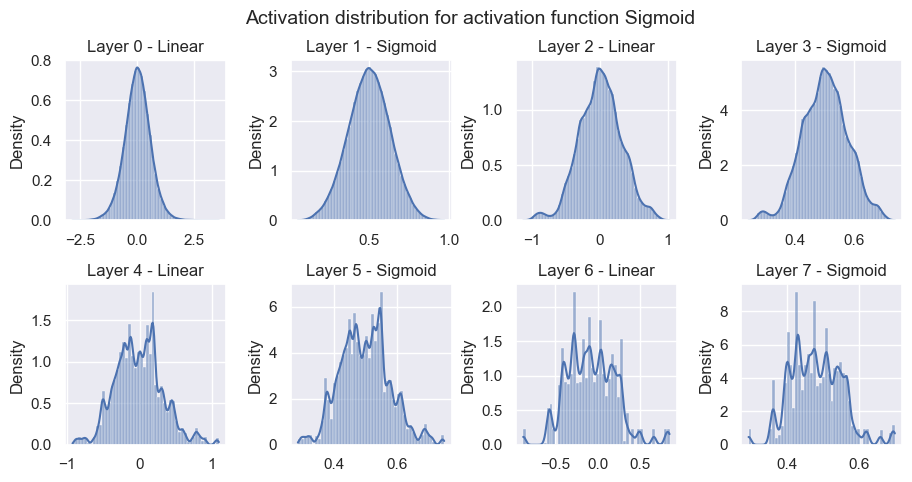

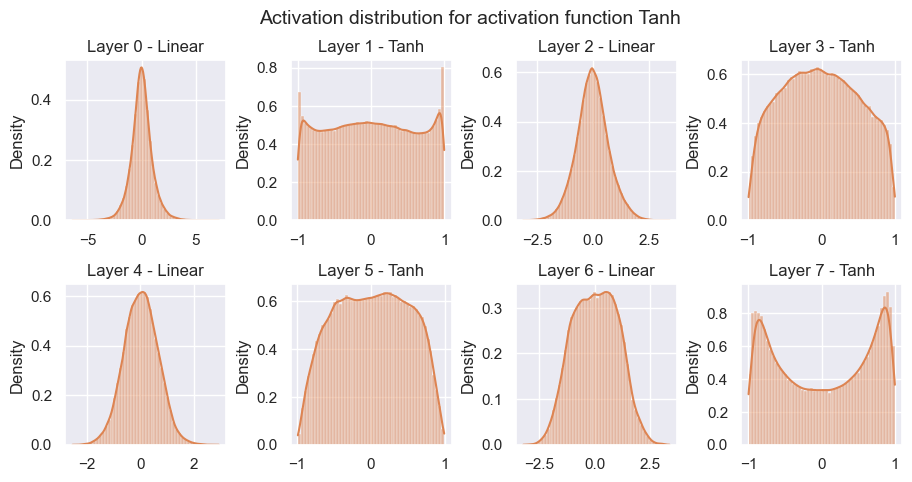

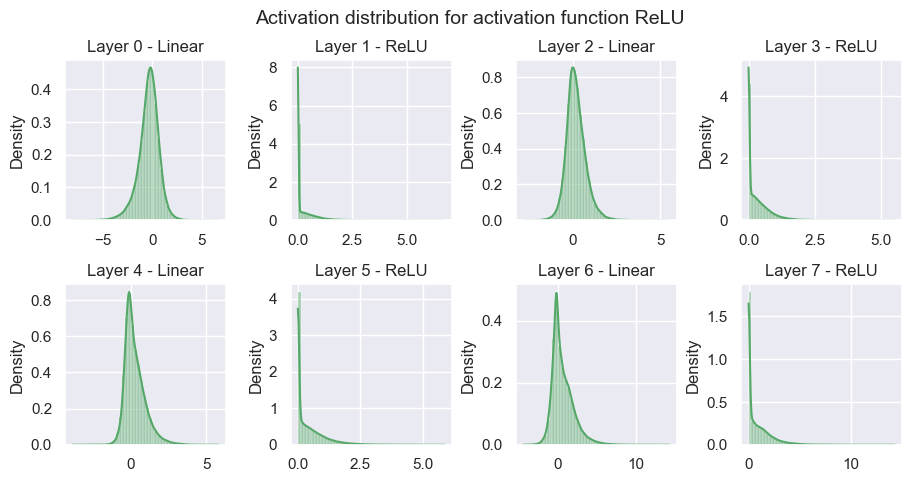

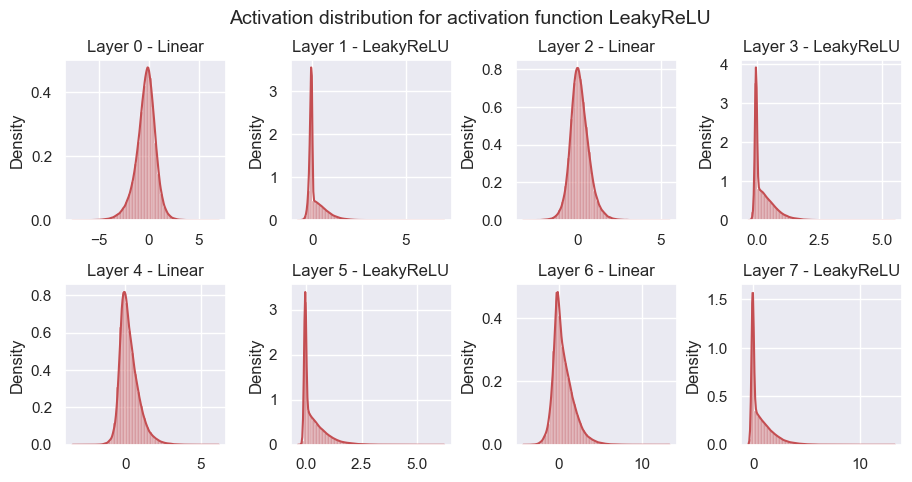

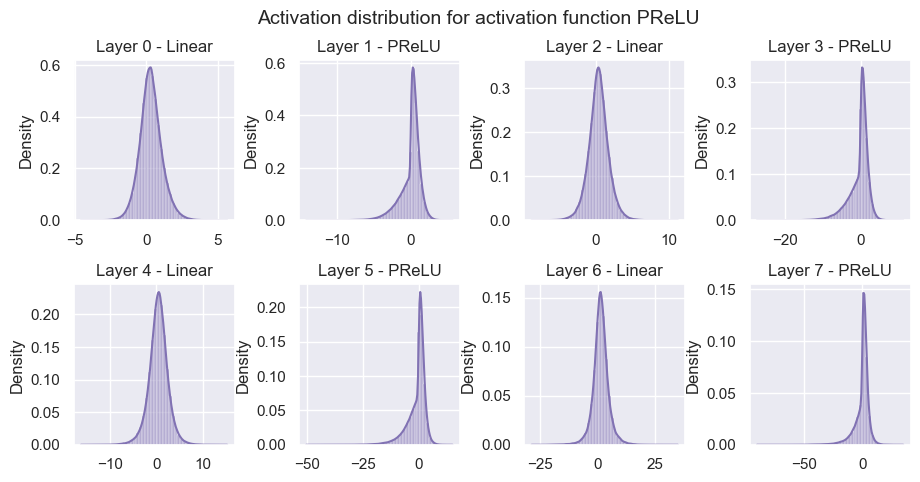

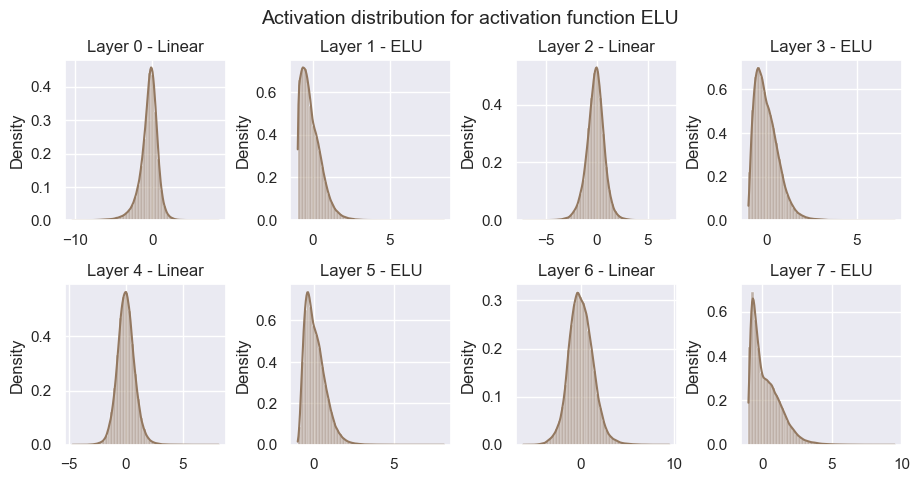

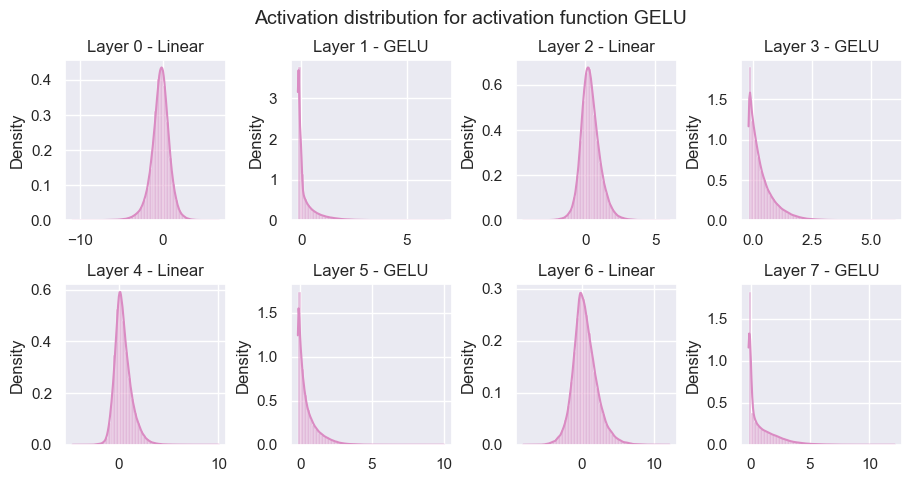

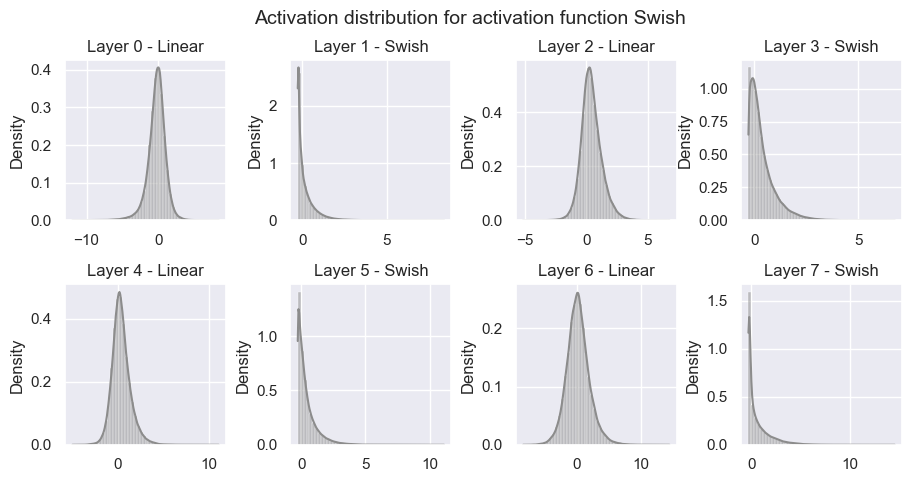

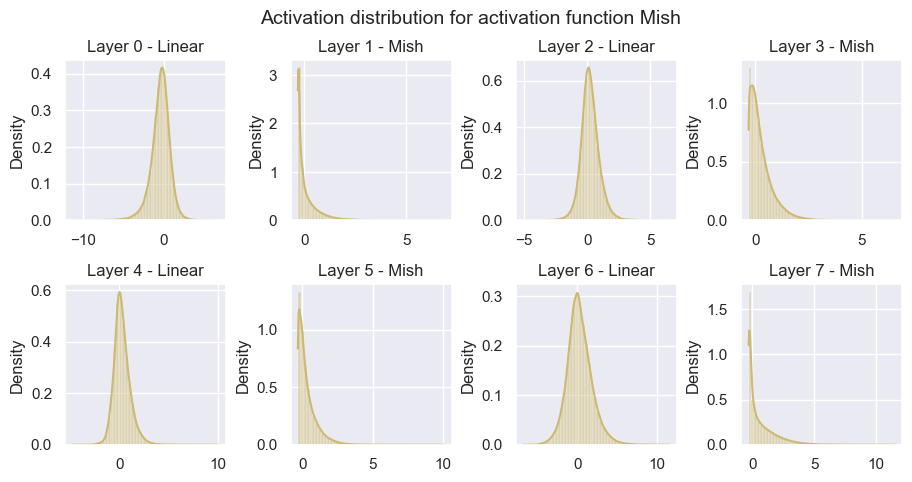

In [37]:
for i, act_fn_name in enumerate(dict_act_fn):
    net_actfn = load_model(model_path=CHECKPOINT_PATH, model_name=f"FashionMNIST_{act_fn_name}").to(device)
    visualize_activations(net_actfn, color=f"C{i}")

#### dead neurons

「デッド・ニューロン」とは、どのような学習入力に対しても勾配がないニューロンのことです。dead neuronsが発生するケースは、ReLUの前の線形層の特定のニューロンの出力値が、すべての入力画像に対して負でなければならなリません。これはあまりないケースにも思えますが、NNのニューロン数が多いことを考えると可能性としては低くはありません。

これがどの程度の問題なのか、またどのような場合に注意が必要なのかを知るために、異なるネットワークにどれだけのデッドニューロンがあるのかを測定することにする。そのために、あるニューロンがすべてのデータポイントに対して0であるかどうかを記録する関数を実装します。

In [38]:
def measure_number_dead_neurons(net):
    # For each neuron, we create a boolean variable initially set to 1. If it has an activation unequals 0 at any time,
    # we set this variable to 0. After running through the whole training set, only dead neurons will have a 1.
    neurons_dead = [
        torch.ones(layer.weight.shape[0], device=device) for layer in net.layers[:-1] if isinstance(layer, nn.Linear)
    ] # Same shapes as hidden size in BaseNetwork
    net.eval()
    with torch.no_grad():
        for imgs, labels in tqdm(train_loader, leave=False): # Run through whole training set
            layer_index = 0
            imgs = imgs.to(device)
            imgs = imgs.view(imgs.size(0), -1)
            for layer in net.layers[:-1]:
                imgs = layer(imgs)
                if isinstance(layer, BaseActivationFunc):
                    # Are all activations == 0 in the batch, and we did not record the opposite in the last batches?
                    neurons_dead[layer_index] = torch.logical_and(neurons_dead[layer_index], (imgs == 0).all(dim=0))
                    layer_index += 1
    number_neurons_dead = [t.sum().item() for t in neurons_dead]
    print("Number of dead neurons:", number_neurons_dead)
    print("In percentage:", ", ".join([f"{(100.0 * num_dead / tens.shape[0]):4.2f}%" for tens, num_dead in zip(neurons_dead, number_neurons_dead)]))

訓練されてないモデルでは、dead neuronsはほとんどないです。

In [39]:
set_seed(42)
net_relu = BaseNetwork(act_fn=ReLU).to(device)
measure_number_dead_neurons(net_relu)

Number of dead neurons: [0, 0, 0, 6]
In percentage: 0.00%, 0.00%, 0.00%, 4.69%


学習済みのモデルでは、わずかにdead neuronsの数が減っています。このように後ろの層では、学習が進むにつれてニューロンがアクティブになる可能性があります。しかし、入力層に近いニューロンでdead neuronsがある場合、入力データは変わらないでのdead neuronsのままである可能性があります。

In [45]:
net_relu = load_model(model_path=CHECKPOINT_PATH, model_name="FashionMNIST_relu").to(device)
measure_number_dead_neurons(net_relu)

Number of dead neurons: [0, 0, 1, 4]
In percentage: 0.00%, 0.00%, 0.39%, 3.12%


層の数を増やすと、50 %以上のニューロンが死んでいる層もあり、かなりのボトルネックになっていることがわかります。そのため、非常に深いネットワークには、Swishのような他の非線形性を持つ活性化関数を使用することが望ましいです。

In [48]:
set_seed(42)
net_relu = BaseNetwork(act_fn=ReLU, hidden_sizes=[256, 256, 256, 256, 256, 128, 128, 128, 128, 128]).to(device)
measure_number_dead_neurons(net_relu)

Number of dead neurons: [0, 0, 1, 14, 72, 57, 58, 61, 71, 56]
In percentage: 0.00%, 0.00%, 0.39%, 5.47%, 28.12%, 44.53%, 45.31%, 47.66%, 55.47%, 43.75%


 Swishにするとdead neuronsが０なっていることがわかります。このようにSwishのようなReLUから派生した関数はReLUのdead neurons問題を解決することができます。

In [54]:
set_seed(42)
net_relu = BaseNetwork(act_fn=Swish, hidden_sizes=[256, 256, 256, 256, 256, 128, 128, 128, 128, 128]).to(device)
measure_number_dead_neurons(net_relu)

Number of dead neurons: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
In percentage: 0.00%, 0.00%, 0.00%, 0.00%, 0.00%, 0.00%, 0.00%, 0.00%, 0.00%, 0.00%


以上を踏まえると、自身で学習する場合はReLUベースからスタートし、各ネットワークや他の設定に合う活性化関数に調整していく方針が良さそうですね。